# ResNet-based Conditional Variational Autoencoder (CVAE)

This notebook implements a sophisticated Conditional VAE using ResNet blocks for both encoder and decoder.
The model can generate images conditioned on class labels, allowing for controlled generation.

## Key Features:
- **ResNet Encoder**: Deep residual blocks for feature extraction
- **Conditional Architecture**: Class conditioning throughout the network
- **ResNet Decoder**: Transposed convolutions with skip connections
- **β-VAE Support**: Controllable disentanglement
- **Advanced Training**: Proper loss balancing and monitoring

## Imports and Setup

In [ ]:
!pip install -U  huggingface_hub datasets


In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet34

import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
import math
from tqdm import tqdm
from typing import List

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## Data Loading and Preprocessing

In [191]:
# Load CIFAR-10 dataset for more complex images
dataset = load_dataset("cifar10")
print(f"Dataset info: {dataset}")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

# Define transforms for CIFAR-10 (32x32 RGB images)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['img']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets
train_dataset = CIFAR10Dataset(dataset['train'], transform=transform)
test_dataset = CIFAR10Dataset(dataset['test'], transform=transform)

# Create data loaders
batch_size = 64
# in coillab or multi-gpu, use 2 workers, else use 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of classes: {num_classes}")

Dataset info: DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})
Train samples: 50000
Test samples: 10000
Batch size: 64
Number of classes: 10


## Data Visualization

Batch shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])


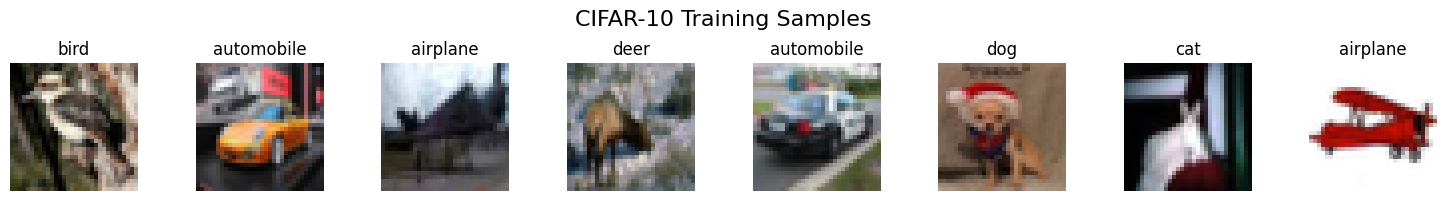

In [192]:
# Visualize some samples
def show_images(images, labels, num_images=8, title="Images"):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f'{class_names[labels[i].item()]}')
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Get a batch and visualize
sample_batch = next(iter(train_loader))
sample_images, sample_labels = sample_batch
print(f"Batch shape: {sample_images.shape}")
print(f"Labels shape: {sample_labels.shape}")
show_images(sample_images, sample_labels, title="CIFAR-10 Training Samples")

## ResNet Building Blocks

In [208]:
class ResNetBlock(nn.Module):
    """Basic ResNet block with optional conditioning"""
    def __init__(self, in_channels:int, y_embed_dim=int):
        super(ResNetBlock, self).__init__()

        self.block1 = nn.Sequential(
            # nn.BatchNorm2d(in_channels),
            nn.GroupNorm(32, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3,  padding=1),
        )
        self.block2 = nn.Sequential(
            # nn.BatchNorm2d(in_channels), # apperently Film hates batchnorm
            nn.GroupNorm(32, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
        )

        # Conditional batch normalization (optional)
        # TODO: test mlp vs just nn.embedding
        self.y_adapter = nn.Sequential(
            nn.Linear(y_embed_dim, y_embed_dim),
            nn.SiLU(),
            nn.Linear(y_embed_dim, in_channels * 2)
        )

        # self.y_adapter = nn.Embedding(num_classes, out_channels * 2)

    def film(self, h, y_embed):
      gamma, beta = self.y_adapter(y_embed).chunk(2, dim=1)  # [bs, c] each
      gamma = gamma.unsqueeze(-1).unsqueeze(-1)  # [bs, c, 1, 1]
      beta = beta.unsqueeze(-1).unsqueeze(-1)   # [bs, c, 1, 1]
      return gamma * h + beta # [bs, c, h, w]


    def forward(self, x: torch.Tensor, y_embed: torch.Tensor):
        """
        Args:
        - x: (bs, c, h, w)
        - y_embed: (bs, y_embed_dim)
        """
        res = x # (bs, c, h, w)

        # Initial conv block
        x = self.block1(x) # (bs, c, h, w)

        # Add y embedding
        x = self.film(x, y_embed)

        # Second conv block
        x = self.block2(x) # (bs, c, h, w)

        # Add y embedding
        x = self.film(x, y_embed)

        # Add residual
        x = x + res # (bs, c, h, w)

        return x

class ResNetEncoder(nn.Module):
    """ResNet-based encoder block for CVAE"""
    def __init__(self, in_channels:int, out_channels:int, num_residual_blocks:int, y_embed_dim:int):
        super(ResNetEncoder, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_residual_blocks = num_residual_blocks
        self.y_embed_dim = y_embed_dim

        self.res_blocks = nn.ModuleList([
            ResNetBlock(in_channels, y_embed_dim=y_embed_dim) for _ in range(num_residual_blocks)
        ])

        self.downsample = nn.Sequential(
            # nn.BatchNorm2d(in_channels),
            nn.GroupNorm(32, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
        )

    def forward(self, x: torch.Tensor, y_embed: torch.Tensor):
        """
        Args:
        - x: (bs, c_in, h, w)
        - y_embed: (bs, y_embed_dim)
        """
        # Pass through residual blocks: (bs, c_in, h, w) -> (bs, c_in, h, w)
        for block in self.res_blocks:
            x = block(x, y_embed)

        # Downsample: (bs, c_in, h, w) -> (bs, c_out, h, w)
        x = self.downsample(x)

        return x

class ResNetDecoder(nn.Module):
    """ResNet-based decoder for CVAE"""
    def __init__(self, in_channels:int, out_channels:int, num_residual_blocks:int, y_embed_dim:int):
        super(ResNetDecoder, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_residual_blocks = num_residual_blocks
        self.y_embed_dim = y_embed_dim

        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(32, out_channels),
            # nn.BatchNorm2d(out_channels),
            nn.SiLU(),
        )

        self.res_blocks = nn.ModuleList([
            ResNetBlock(out_channels, y_embed_dim=y_embed_dim) for _ in range(num_residual_blocks)
        ])

    def forward(self, x: torch.Tensor, y_embed: torch.Tensor):
        """
        Args:
        - x: (bs, c_in, h, w)
        - y_embed: (bs, y_embed_dim)
        """
        # Upsample: (bs, c_in, h, w) -> (bs, c_out, 2 * h, 2 * w)
        x = self.upsample(x)

        # Pass through residual blocks: (bs, c_out, h, w) -> (bs, c_out, 2 * h, 2 * w)
        for block in self.res_blocks:
            x = block(x, y_embed)

        return x

## ResNet-based Conditional VAE Architecture

In [236]:
class ResNetCVAE(nn.Module):
    """Complete ResNet-based Conditional VAE"""
    def __init__(self, channels:List[int], num_residual_blocks:int, num_classes: int, y_embed_dim: int, latent_dim: int):
        super(ResNetCVAE, self).__init__()

        self.channels = channels
        self.num_residual_blocks = num_residual_blocks
        self.num_classes = num_classes
        self.y_embed_dim = y_embed_dim
        self.latent_dim = latent_dim

        # Initial convolution: (bs, 3, 32, 32) -> (bs, c_0, 32, 32)
        self.init_conv = nn.Sequential(
            nn.Conv2d(3, channels[0], kernel_size=3, padding=1),
            nn.GroupNorm(8, channels[0]),
            nn.SiLU(),
        )

        self.y_embedder = nn.Embedding(num_embeddings=num_classes, embedding_dim = y_embed_dim)

        encoders = []
        decoders = []
        for (curr_c, next_c) in zip(channels[:-1], channels[1:]):
            encoders.append(ResNetEncoder(curr_c, next_c, num_residual_blocks, y_embed_dim))
            decoders.append(ResNetDecoder(next_c, curr_c, num_residual_blocks, y_embed_dim))
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))

        # calculate layers before and after latent space
        input_size = 32  # Starting image size
        num_encoders = len(channels) - 1  # Number of downsampling operations
        self.final_size = input_size // (2 ** num_encoders)  # Each encoder halves the spatial dimensions
        self.final_channels = channels[-1]  # Number of channels in the final feature map
        final_feature_map_size = self.final_size * self.final_size * self.final_channels
        # if channels = [32, 64, 128], then 32/2/2 = 8, 8^2 * 128 = 192
        print(f"Network architecture: {channels}")
        print(f"Final feature dimensions: {self.final_size}x{self.final_size}x{ self.final_channels}")
        print(f"Flattened feature size: {final_feature_map_size}")

        # Latent space projections
        self.mu_conv     = nn.Conv2d(self.final_channels + y_embed_dim, latent_dim, kernel_size=1)
        self.logvar_conv = nn.Conv2d(self.final_channels + y_embed_dim, latent_dim, kernel_size=1)

        # Initial projection from latent space
        self.latent_proj = nn.Conv2d(latent_dim + y_embed_dim, self.final_channels, kernel_size=1)
        self.latent_mixer = ResNetBlock(self.final_channels, y_embed_dim=y_embed_dim)

        # Final convolution with tanh to output [-1, 1]
        self.final_conv_tanh = nn.Sequential(
            nn.GroupNorm(8, channels[0]),
            nn.SiLU(),
            nn.Conv2d(channels[0], 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def encode(self, x: torch.Tensor, y: torch.Tensor):
        """Encode input to latent parameters
        Args:
            - x: (bs, 1, 32, 32)
            - y: (bs,)
        Returns:
            - mu: (bs, latent_dim)
            - logvar: (bs, latent_dim)
        """
        # Embed y
        y_embed = self.y_embedder(y) # (bs, y_embed_dim)

        # Initial convolution
        x = self.init_conv(x) # (bs, c_0, 32, 32)

        # Encoders
        for encoder in self.encoders:
            x = encoder(x, y_embed) # (bs, c_i, h, w) -> (bs, c_{i+1}, h // 2, w //2)

        x = torch.cat([x, y_embed[:,:,None,None].expand(-1,-1,x.size(2),x.size(3))], 1)

        # Project to latent parameters
        mu = self.mu_conv(x)
        logvar = self.logvar_conv(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z: torch.Tensor, class_label: torch.Tensor):
        """Decode latent code to reconstruction
        args :
        - z: (bs, latent_dim)
        - class_label: (bs,)
        returns:
        - recon_x: (bs, 1, 32, 32)
        """
        # Get class embedding
        y_embed = self.y_embedder(class_label)

        x = torch.cat([z, y_embed[:,:,None,None].expand(-1,-1,z.size(2),z.size(3))], 1)
        # first conv to mix channels
        x = self.latent_proj(x)   # nn.Conv2d(C_z+y_dim, final_channels, 3, padding=1)
        x = self.latent_mixer(x, y_embed)
        # x = self.latent_mix(x)

        # Pass through decoder blocks with conditioning
        for decoder in self.decoders:
            x = decoder(x, y_embed)

        # Final convolution to output channels
        x = self.final_conv_tanh(x)

        return x

    def forward(self, x: torch.Tensor, class_label:torch.Tensor):
        """Full forward pass"""
        mu, logvar = self.encode(x, class_label)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, class_label)
        return recon_x, mu, logvar

    def sample(self, num_samples:int, class_label, device):
        """Generate samples from the prior"""
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim, self.final_size, self.final_size).to(device)
            if isinstance(class_label, int):
                class_label = torch.full((num_samples,), class_label, dtype=torch.long).to(device)
            samples = self.decode(z, class_label)
            return samples


# Create the model
latent_dim = 32
y_embed_dim = 64
model = ResNetCVAE(channels=[64, 128, 256, 512], num_residual_blocks=2, num_classes=num_classes, y_embed_dim=y_embed_dim, latent_dim=latent_dim).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"ResNet CVAE Model:")
print(f"  Input channels: {model.channels}")
print(f"  Latent dimension: {model.latent_dim}")
print(f"  Number of classes: {model.num_classes}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: {total_params * 4 / 1024 / 1024:.2f} MB")

Network architecture: [64, 128, 256, 512]
Final feature dimensions: 4x4x512
Flattened feature size: 8192
ResNet CVAE Model:
  Input channels: [64, 128, 256, 512]
  Latent dimension: 32
  Number of classes: 10
  Total parameters: 14,469,891
  Trainable parameters: 14,469,891
  Model size: 55.20 MB


## CVAE Loss Function

In [237]:
def cvae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    Conditional VAE loss = Reconstruction Loss + β * KL Divergence

    Args:
        recon_x: Reconstructed images [batch_size, channels, height, width]
        x: Original images [batch_size, channels, height, width]
        mu: Mean of latent distribution [batch_size, latent_dim, latent_height, latent_width]
        logvar: Log variance of latent distribution [batch_size, latent_height, latent_width]
        beta: Weight for KL divergence (β-VAE parameter)
    """

     # L1 loss for sharper reconstructions
    l1_loss = F.l1_loss(recon_x, x, reduction='sum')

    # Optional: combine with small amount of MSE
    mse_loss = F.mse_loss(recon_x, x, reduction='sum')

    # Using reduction='sum' and dividing by batch_size is more stable
    recon_loss = (0.9 * l1_loss + 0.1 * mse_loss) / x.size(0)

    # KL loss
    # KL(q(z|x,c) || p(z)) where p(z) = N(0,1)
    # We sum over the latent dimensions (C, H, W) and then average over the batch
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=[1, 2, 3])
    kl_loss = torch.mean(kl_divergence)

    # Total CVAE Loss
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss


# Test the model and loss function
with torch.no_grad():
    # Get a sample batch
    sample_images, sample_labels = next(iter(train_loader))
    sample_images = sample_images.to(device)
    sample_labels = sample_labels.to(device)

    print(f"Input shape: {sample_images.shape}")
    print(f"Labels shape: {sample_labels.shape}")
    print(sample_labels[0])

    # Forward pass
    recon_batch, mu, logvar = model(sample_images, sample_labels)

    # Calculate loss
    total_loss, recon_loss, kl_loss = cvae_loss(recon_batch, sample_images, mu, logvar)

    print(f"\nModel outputs:")
    print(f"  Reconstruction shape: {recon_batch.shape}")
    print(f"  Mu shape: {mu.shape}")
    print(f"  Logvar shape: {logvar.shape}")
    print(f"\nLoss breakdown:")
    print(f"  Reconstruction Loss: {recon_loss.item():.2f}")
    print(f"  KL Divergence Loss: {kl_loss.item():.2f}")
    print(f"  Total Loss: {total_loss.item():.2f}")

Input shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
tensor(8, device='cuda:0')

Model outputs:
  Reconstruction shape: torch.Size([64, 3, 32, 32])
  Mu shape: torch.Size([64, 32, 4, 4])
  Logvar shape: torch.Size([64, 32, 4, 4])

Loss breakdown:
  Reconstruction Loss: 1472.14
  KL Divergence Loss: 26.01
  Total Loss: 1498.16


In [238]:
# over-fit TEN images for 1 000 steps
subset_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(train_dataset, range(10)),
        batch_size=10, shuffle=True)

opt = torch.optim.AdamW(model.parameters(), lr=5e-4)
for i in range(1_000):
    img, lab = next(iter(subset_loader)); img, lab = img.to(device), lab.to(device)
    recon, mu, logvar = model(img, lab)
    loss, rec, kl = cvae_loss(recon, img, mu, logvar, beta=0)   # β=0 for this test
    opt.zero_grad(); loss.backward(); opt.step()
print('PSNR:', -10*torch.log10(((recon-img)**2).mean()).item())

PSNR: 37.95645475387573


## Training Setup

In [239]:
# Training hyperparameters
learning_rate = 3e-4
num_epochs = 15
# beta = 0.1 # β-VAE parameter
beta   = 0.01 # 0.05–0.25 for CIFAR-10-size images
warmup_epochs = 5  # KL warmup

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# For tracking losses
train_losses = []
recon_losses = []
kl_losses = []
test_losses = []

print(f"Training Configuration:")
print(f"  Learning Rate: {learning_rate}")
print(f"  Epochs: {num_epochs}")
print(f"  Beta (β-VAE): {beta}")
print(f"  Warmup Epochs: {warmup_epochs}")
print(f"  Optimizer: Adam with weight decay")
print(f"  Scheduler: CosineAnnealingLR")
print(f"  Device: {device}")

Training Configuration:
  Learning Rate: 0.0003
  Epochs: 15
  Beta (β-VAE): 0.01
  Warmup Epochs: 5
  Optimizer: Adam with weight decay
  Scheduler: CosineAnnealingLR
  Device: cuda


## Training Functions

In [240]:
def train_epoch(model, train_loader, optimizer, epoch, beta=1.0, warmup_epochs=5):
    """Train CVAE for one epoch"""
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    total_batches = len(train_loader) # ① batches per epoch


    # KL warmup: gradually increase beta
    # if epoch < warmup_epochs:
    #     current_beta = beta * min(1.0, epoch / warmup_epochs)
    # else:
    #     current_beta = beta

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}')

    for batch_idx, (data, labels) in enumerate(progress_bar):
        step_in_training = epoch * total_batches + batch_idx       # ② global step
        warmup_steps     = warmup_epochs * total_batches           # ③ total ramp
        current_beta = beta * min(1.0, step_in_training / warmup_steps)

        data = data.to(device)
        labels = labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data, labels)

        # Calculate loss
        loss, recon_loss, kl_loss = cvae_loss(recon_batch, data, mu, logvar, current_beta)

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Accumulate losses
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Recon': f'{recon_loss.item():.4f}',
            'KL': f'{kl_loss.item():.4f}',
            'Beta': f'{current_beta:.3f}'
        })

    # Return average losses
    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon_loss / len(train_loader)
    avg_kl = total_kl_loss / len(train_loader)

    return avg_loss, avg_recon, avg_kl


def test_epoch(model, test_loader, beta=1.0):
    """Evaluate CVAE on test set"""
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            # Forward pass
            recon_batch, mu, logvar = model(data, labels)

            # Calculate loss
            loss, recon_loss, kl_loss = cvae_loss(recon_batch, data, mu, logvar, beta)

            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()

    # Return average losses
    avg_loss = total_loss / len(test_loader)
    avg_recon = total_recon_loss / len(test_loader)
    avg_kl = total_kl_loss / len(test_loader)

    return avg_loss, avg_recon, avg_kl

## Training Loop

In [241]:
# Main training loop
print("Starting ResNet CVAE Training...\n")

best_test_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)

    # Train
    train_loss, train_recon, train_kl = train_epoch(
        model, train_loader, optimizer, epoch, beta, warmup_epochs
    )

    # Test
    test_loss, test_recon, test_kl = test_epoch(model, test_loader, beta)

    # Update scheduler
    scheduler.step()

    # Store losses
    train_losses.append(train_loss)
    recon_losses.append(train_recon)
    kl_losses.append(train_kl)
    test_losses.append(test_loss)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f})")
    print(f"  Test Loss:  {test_loss:.4f} (Recon: {test_recon:.4f}, KL: {test_kl:.4f})")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_loss': test_loss,
        }, 'best_resnet_cvae_0001.pth')
        print(f"  ✓ New best model saved (test loss: {test_loss:.4f})")

print("\n🎉 Training completed!")
print(f"Best test loss: {best_test_loss:.4f}")

Starting ResNet CVAE Training...


Epoch 1/15
------------------------------------------------------------


Epoch 1: 100%|██████████| 782/782 [01:02<00:00, 12.45it/s, Loss=286.5140, Recon=281.9083, KL=2305.7974, Beta=0.002]



Epoch 1 Summary:
  Train Loss: 357.9931 (Recon: 355.0653, KL: 3826.8407)
  Test Loss:  284.9110 (Recon: 261.8524, KL: 2305.8591)
  Learning Rate: 0.000297
  ✓ New best model saved (test loss: 284.9110)

Epoch 2/15
------------------------------------------------------------


Epoch 2: 100%|██████████| 782/782 [01:02<00:00, 12.43it/s, Loss=216.0676, Recon=208.7402, KL=1832.9998, Beta=0.004]



Epoch 2 Summary:
  Train Loss: 231.6477 (Recon: 225.7134, KL: 2003.5764)
  Test Loss:  220.7694 (Recon: 202.5195, KL: 1824.9972)
  Learning Rate: 0.000287
  ✓ New best model saved (test loss: 220.7694)

Epoch 3/15
------------------------------------------------------------


Epoch 3: 100%|██████████| 782/782 [01:02<00:00, 12.48it/s, Loss=168.8876, Recon=158.8703, KL=1670.2559, Beta=0.006]



Epoch 3 Summary:
  Train Loss: 196.9663 (Recon: 188.2579, KL: 1746.9797)
  Test Loss:  194.1796 (Recon: 177.3050, KL: 1687.4670)
  Learning Rate: 0.000271
  ✓ New best model saved (test loss: 194.1796)

Epoch 4/15
------------------------------------------------------------


Epoch 4: 100%|██████████| 782/782 [01:02<00:00, 12.42it/s, Loss=165.8956, Recon=152.8969, KL=1625.3582, Beta=0.008]



Epoch 4 Summary:
  Train Loss: 178.2454 (Recon: 166.7822, KL: 1639.9611)
  Test Loss:  170.6455 (Recon: 154.6242, KL: 1602.1337)
  Learning Rate: 0.000250
  ✓ New best model saved (test loss: 170.6455)

Epoch 5/15
------------------------------------------------------------


Epoch 5: 100%|██████████| 782/782 [01:02<00:00, 12.45it/s, Loss=162.0647, Recon=146.3391, KL=1572.9575, Beta=0.010]



Epoch 5 Summary:
  Train Loss: 164.9573 (Recon: 150.8618, KL: 1567.6766)
  Test Loss:  160.3771 (Recon: 144.7844, KL: 1559.2768)
  Learning Rate: 0.000225
  ✓ New best model saved (test loss: 160.3771)

Epoch 6/15
------------------------------------------------------------


Epoch 6: 100%|██████████| 782/782 [01:02<00:00, 12.43it/s, Loss=148.1881, Recon=133.0533, KL=1513.4775, Beta=0.010]



Epoch 6 Summary:
  Train Loss: 156.4151 (Recon: 141.0665, KL: 1534.8534)
  Test Loss:  154.9266 (Recon: 139.5467, KL: 1537.9889)
  Learning Rate: 0.000196
  ✓ New best model saved (test loss: 154.9266)

Epoch 7/15
------------------------------------------------------------


Epoch 7: 100%|██████████| 782/782 [01:02<00:00, 12.44it/s, Loss=157.2778, Recon=141.8984, KL=1537.9392, Beta=0.010]



Epoch 7 Summary:
  Train Loss: 149.2772 (Recon: 133.9537, KL: 1532.3498)
  Test Loss:  151.8744 (Recon: 136.4404, KL: 1543.3971)
  Learning Rate: 0.000166
  ✓ New best model saved (test loss: 151.8744)

Epoch 8/15
------------------------------------------------------------


Epoch 8: 100%|██████████| 782/782 [01:03<00:00, 12.32it/s, Loss=141.0725, Recon=125.9772, KL=1509.5275, Beta=0.010]



Epoch 8 Summary:
  Train Loss: 144.6542 (Recon: 129.3699, KL: 1528.4261)
  Test Loss:  144.3371 (Recon: 129.1027, KL: 1523.4429)
  Learning Rate: 0.000134
  ✓ New best model saved (test loss: 144.3371)

Epoch 9/15
------------------------------------------------------------


Epoch 9: 100%|██████████| 782/782 [01:02<00:00, 12.45it/s, Loss=135.3557, Recon=120.2373, KL=1511.8407, Beta=0.010]



Epoch 9 Summary:
  Train Loss: 140.4186 (Recon: 125.1468, KL: 1527.1846)
  Test Loss:  139.6366 (Recon: 124.5279, KL: 1510.8675)
  Learning Rate: 0.000104
  ✓ New best model saved (test loss: 139.6366)

Epoch 10/15
------------------------------------------------------------


Epoch 10: 100%|██████████| 782/782 [01:02<00:00, 12.45it/s, Loss=135.4200, Recon=120.3635, KL=1505.6510, Beta=0.010]



Epoch 10 Summary:
  Train Loss: 136.5759 (Recon: 121.3133, KL: 1526.2547)
  Test Loss:  136.9078 (Recon: 121.6869, KL: 1522.0947)
  Learning Rate: 0.000075
  ✓ New best model saved (test loss: 136.9078)

Epoch 11/15
------------------------------------------------------------


Epoch 11: 100%|██████████| 782/782 [01:02<00:00, 12.52it/s, Loss=128.7922, Recon=113.5418, KL=1525.0422, Beta=0.010]



Epoch 11 Summary:
  Train Loss: 133.7373 (Recon: 118.4692, KL: 1526.8137)
  Test Loss:  134.8121 (Recon: 119.6145, KL: 1519.7600)
  Learning Rate: 0.000050
  ✓ New best model saved (test loss: 134.8121)

Epoch 12/15
------------------------------------------------------------


Epoch 12: 100%|██████████| 782/782 [01:02<00:00, 12.47it/s, Loss=148.0255, Recon=132.6364, KL=1538.9117, Beta=0.010]



Epoch 12 Summary:
  Train Loss: 131.3396 (Recon: 116.0637, KL: 1527.5987)
  Test Loss:  132.8083 (Recon: 117.6418, KL: 1516.6515)
  Learning Rate: 0.000029
  ✓ New best model saved (test loss: 132.8083)

Epoch 13/15
------------------------------------------------------------


Epoch 13: 100%|██████████| 782/782 [01:03<00:00, 12.38it/s, Loss=122.1798, Recon=106.9310, KL=1524.8796, Beta=0.010]



Epoch 13 Summary:
  Train Loss: 129.5650 (Recon: 114.2839, KL: 1528.1130)
  Test Loss:  130.9825 (Recon: 115.6676, KL: 1531.4961)
  Learning Rate: 0.000013
  ✓ New best model saved (test loss: 130.9825)

Epoch 14/15
------------------------------------------------------------


Epoch 14: 100%|██████████| 782/782 [01:02<00:00, 12.42it/s, Loss=119.5153, Recon=104.2339, KL=1528.1385, Beta=0.010]



Epoch 14 Summary:
  Train Loss: 128.3742 (Recon: 113.0816, KL: 1529.2568)
  Test Loss:  129.4898 (Recon: 114.1550, KL: 1533.4786)
  Learning Rate: 0.000003
  ✓ New best model saved (test loss: 129.4898)

Epoch 15/15
------------------------------------------------------------


Epoch 15: 100%|██████████| 782/782 [01:02<00:00, 12.43it/s, Loss=127.8464, Recon=112.5002, KL=1534.6205, Beta=0.010]



Epoch 15 Summary:
  Train Loss: 127.7079 (Recon: 112.4033, KL: 1530.4505)
  Test Loss:  129.1367 (Recon: 113.8386, KL: 1529.8106)
  Learning Rate: 0.000000
  ✓ New best model saved (test loss: 129.1367)

🎉 Training completed!
Best test loss: 129.1367


## Training Visualization and Results

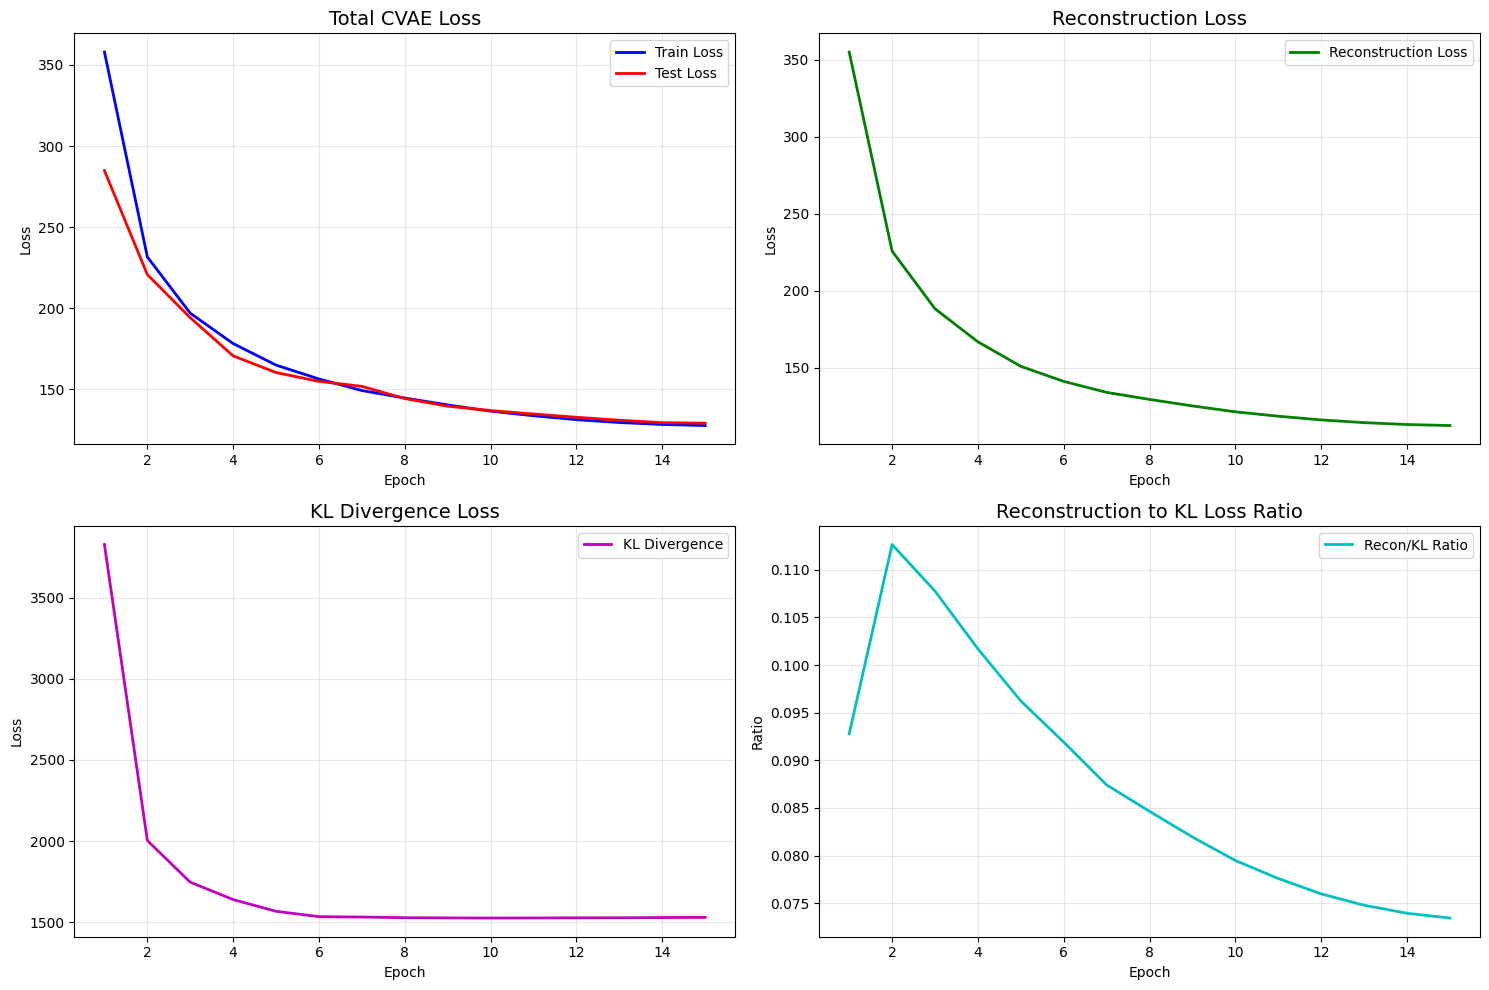

In [242]:
# Plot training losses
def plot_training_curves():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(train_losses) + 1)

    # Total loss
    axes[0, 0].plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
    axes[0, 0].set_title('Total CVAE Loss', fontsize=14)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Reconstruction loss
    axes[0, 1].plot(epochs, recon_losses, 'g-', label='Reconstruction Loss', linewidth=2)
    axes[0, 1].set_title('Reconstruction Loss', fontsize=14)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # KL loss
    axes[1, 0].plot(epochs, kl_losses, 'm-', label='KL Divergence', linewidth=2)
    axes[1, 0].set_title('KL Divergence Loss', fontsize=14)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Loss ratio
    recon_kl_ratio = [r/k if k > 0 else 0 for r, k in zip(recon_losses, kl_losses)]
    axes[1, 1].plot(epochs, recon_kl_ratio, 'c-', label='Recon/KL Ratio', linewidth=2)
    axes[1, 1].set_title('Reconstruction to KL Loss Ratio', fontsize=14)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Ratio')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the curves if we have training data
if len(train_losses) > 0:
    plot_training_curves()

## Reconstruction Visualization

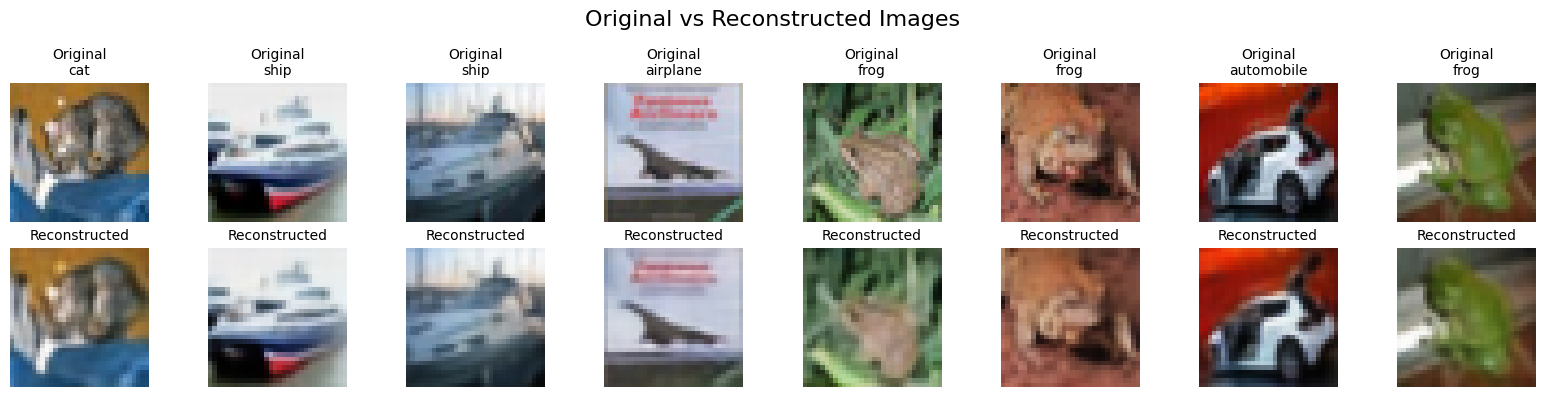

In [243]:
def show_reconstructions(model, test_loader, num_images=8):
    """Show original vs reconstructed images"""
    model.eval()
    with torch.no_grad():
        # Get a batch of test images
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = labels.to(device)

        # Reconstruct
        recon_batch, _, _ = model(data, labels)

        # Convert to numpy and denormalize
        original = data[:num_images].cpu().numpy()
        reconstructed = recon_batch[:num_images].cpu().numpy()
        labels_np = labels[:num_images].cpu().numpy()

        # Denormalize from [-1,1] to [0,1]
        original = (original + 1) / 2
        reconstructed = (reconstructed + 1) / 2

        # Clip to valid range
        original = np.clip(original, 0, 1)
        reconstructed = np.clip(reconstructed, 0, 1)

        # Plot
        fig, axes = plt.subplots(2, num_images, figsize=(16, 4))

        for i in range(num_images):
            # Original
            img_orig = np.transpose(original[i], (1, 2, 0))
            axes[0, i].imshow(img_orig)
            axes[0, i].set_title(f'Original\n{class_names[labels_np[i]]}', fontsize=10)
            axes[0, i].axis('off')

            # Reconstructed
            img_recon = np.transpose(reconstructed[i], (1, 2, 0))
            axes[1, i].imshow(img_recon)
            axes[1, i].set_title('Reconstructed', fontsize=10)
            axes[1, i].axis('off')

        plt.suptitle('Original vs Reconstructed Images', fontsize=16)
        plt.tight_layout()
        plt.show()

# Show reconstructions
show_reconstructions(model, test_loader)

## Conditional Generation

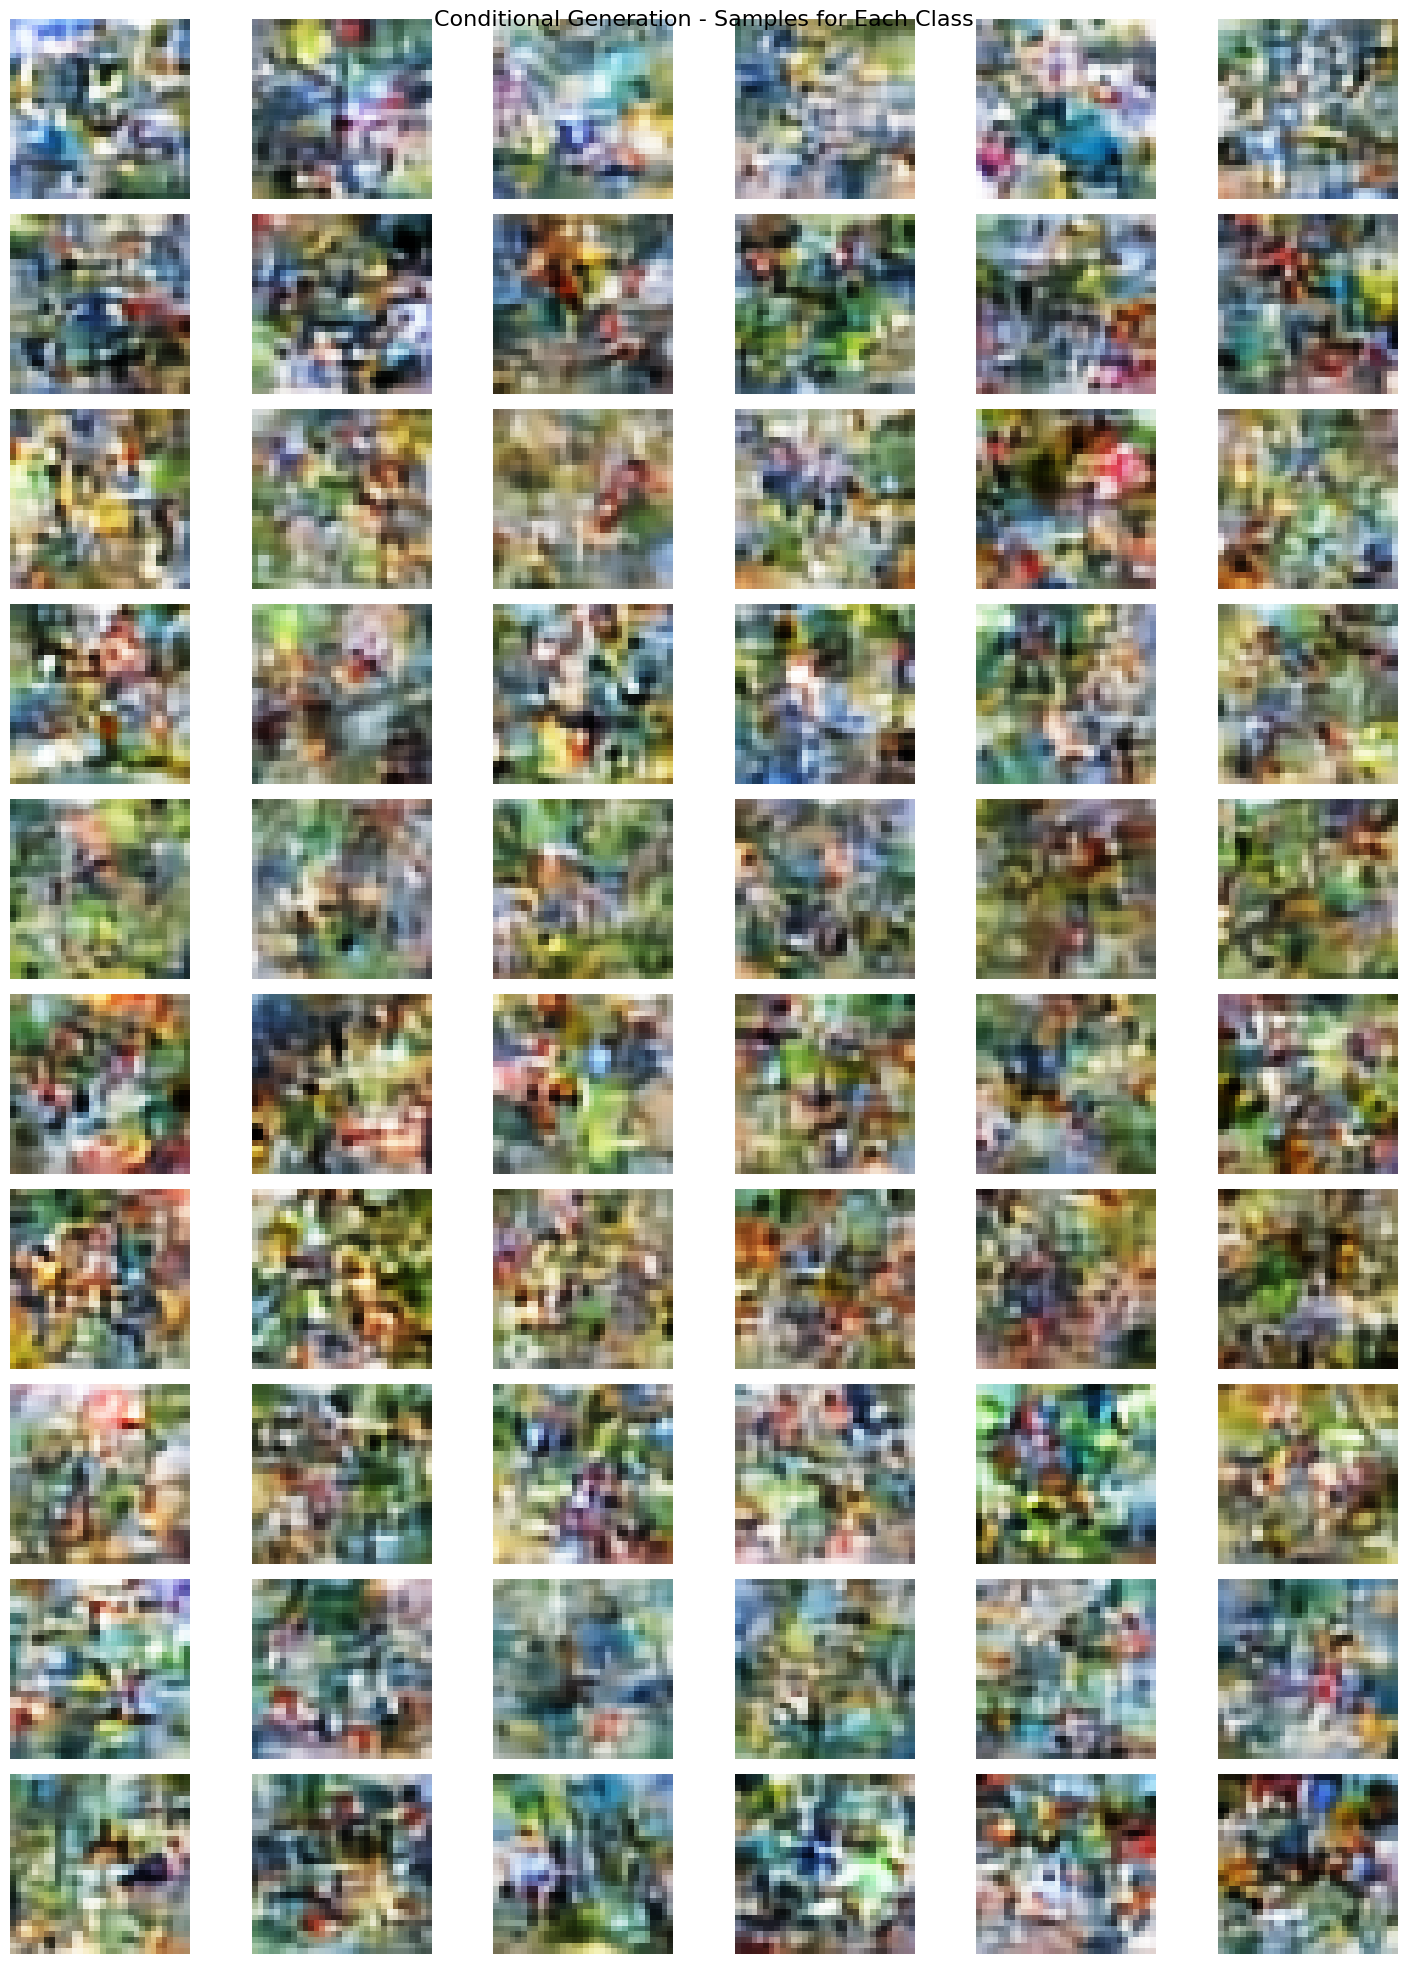

In [244]:
def generate_conditional_samples(model, num_samples_per_class=5):
    """Generate samples for each class"""
    model.eval()

    fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(15, 20))

    with torch.no_grad():
        for class_idx in range(num_classes):
            # Generate samples for this class
            samples = model.sample(num_samples_per_class, class_idx, device)

            # Convert to numpy and denormalize
            samples = samples.cpu().numpy()
            samples = (samples + 1) / 2  # [-1,1] to [0,1]
            samples = np.clip(samples, 0, 1)

            for sample_idx in range(num_samples_per_class):
                img = np.transpose(samples[sample_idx], (1, 2, 0))
                axes[class_idx, sample_idx].imshow(img)

                if sample_idx == 0:
                    axes[class_idx, sample_idx].set_ylabel(class_names[class_idx],
                                                          fontsize=12, rotation=0,
                                                          ha='right', va='center')

                axes[class_idx, sample_idx].axis('off')

    plt.suptitle('Conditional Generation - Samples for Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate conditional samples
generate_conditional_samples(model, num_samples_per_class=6)

## Latent Space Interpolation

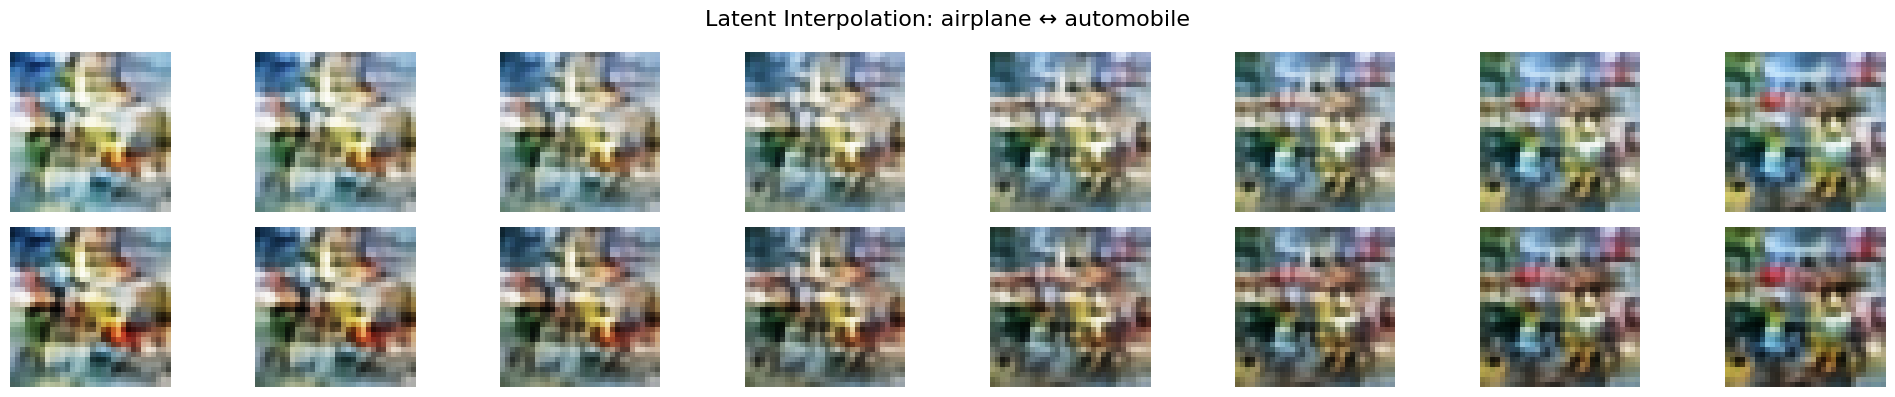

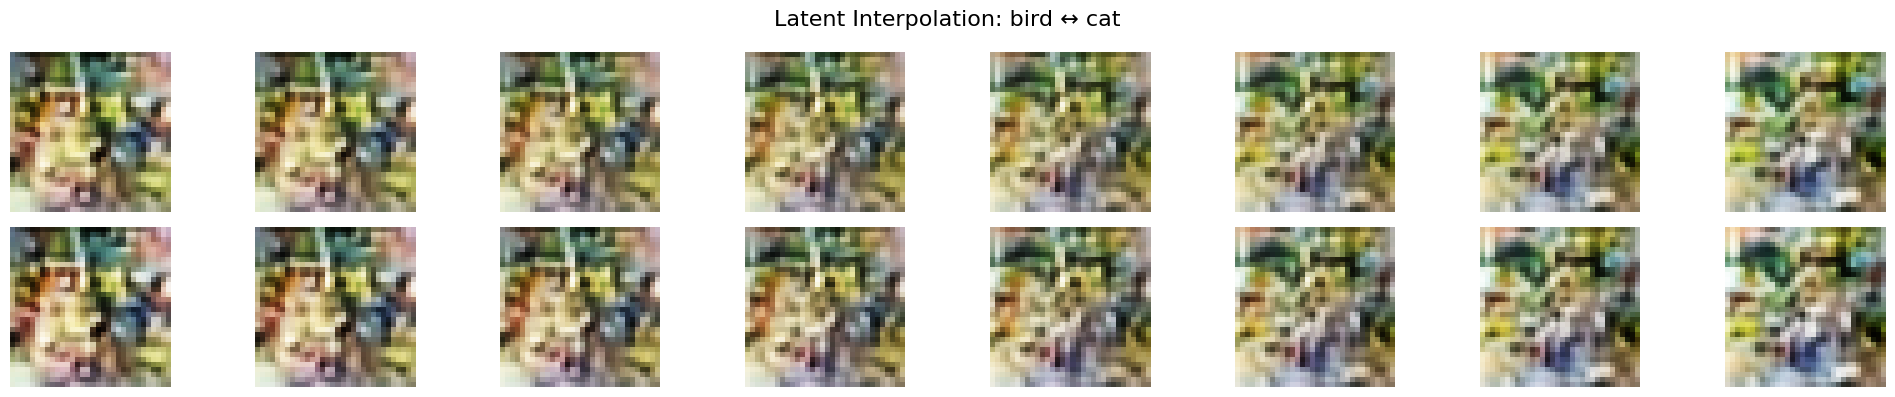

In [245]:
def interpolate_between_classes(model, class1, class2, num_steps=10):
    """Interpolate between two classes in latent space"""
    model.eval()

    with torch.no_grad():
        # Sample random latent codes
        z1 = torch.randn(1, model.latent_dim, model.final_size, model.final_size).to(device)
        z2 = torch.randn(1, model.latent_dim, model.final_size, model.final_size).to(device)

        # Create interpolation steps
        alphas = torch.linspace(0, 1, num_steps).to(device)

        fig, axes = plt.subplots(2, num_steps, figsize=(20, 4))

        for i, alpha in enumerate(alphas):
            # Interpolate latent codes
            z_interp = (1 - alpha) * z1 + alpha * z2

            # Generate with class1
            class1_tensor = torch.tensor([class1]).to(device)
            sample1 = model.decode(z_interp, class1_tensor)

            # Generate with class2
            class2_tensor = torch.tensor([class2]).to(device)
            sample2 = model.decode(z_interp, class2_tensor)

            # Convert and display
            for j, sample in enumerate([sample1, sample2]):
                img = sample.cpu().numpy()[0]
                img = (img + 1) / 2
                img = np.clip(img, 0, 1)
                img = np.transpose(img, (1, 2, 0))

                axes[j, i].imshow(img)
                axes[j, i].axis('off')

                if i == 0:
                    class_name = class_names[class1] if j == 0 else class_names[class2]
                    axes[j, i].set_ylabel(class_name, fontsize=12, rotation=0,
                                         ha='right', va='center')

        plt.suptitle(f'Latent Interpolation: {class_names[class1]} ↔ {class_names[class2]}',
                    fontsize=16)
        plt.tight_layout()
        plt.show()

# Interpolate between different classes
interpolate_between_classes(model, 0, 1, num_steps=8)  # airplane to automobile
interpolate_between_classes(model, 2, 3, num_steps=8)  # bird to cat

## Latent Space Visualization

Running t-SNE on 500 samples...


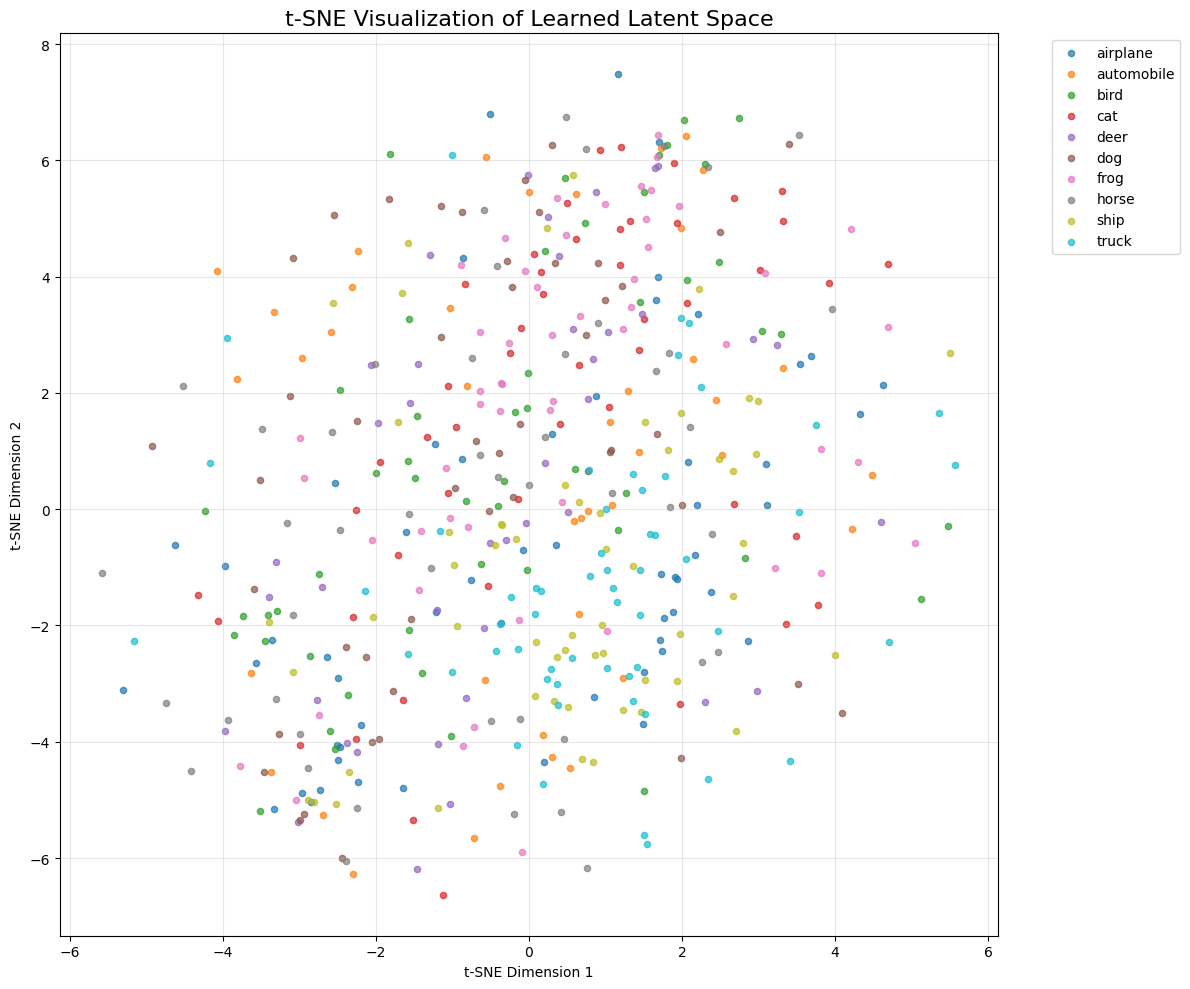

In [246]:
def visualize_latent_space(model, test_loader, num_samples=1000):
    """Visualize the learned latent space using t-SNE"""
    from sklearn.manifold import TSNE
    import matplotlib.colors as mcolors

    model.eval()
    latent_codes = []
    labels_list = []

    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            if len(latent_codes) * data.size(0) >= num_samples:
                break

            data = data.to(device)
            labels = labels.to(device)

            # Encode to latent space
            mu, logvar = model.encode(data, labels)
            z = model.reparameterize(mu, logvar)

            # FIX: Flatten the spatial latent code into a vector for t-SNE
            z_flat = z.view(z.size(0), -1)

            latent_codes.append(z_flat.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    # Concatenate all latent codes and labels
    latent_codes = np.concatenate(latent_codes, axis=0)[:num_samples]
    labels_array = np.concatenate(labels_list, axis=0)[:num_samples]

    print(f"Running t-SNE on {len(latent_codes)} samples...")

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    latent_2d = tsne.fit_transform(latent_codes)

    # Plot
    plt.figure(figsize=(12, 10))

    # Create a color map
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    for class_idx in range(num_classes):
        mask = labels_array == class_idx
        plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1],
                   c=[colors[class_idx]], label=class_names[class_idx],
                   alpha=0.7, s=20)

    plt.title('t-SNE Visualization of Learned Latent Space', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize latent space
try:
    visualize_latent_space(model, test_loader, num_samples=500)
except ImportError:
    print("sklearn not available. Install with: pip install scikit-learn")

## Model Analysis and Summary

In [247]:
def analyze_model_performance():
    """Analyze and summarize model performance"""
    print("🔍 ResNet CVAE Model Analysis")
    print("=" * 50)

    # Architecture summary
    print(f"\n📐 Architecture:")
    print(f"  • Input: 3×32×32 (CIFAR-10)")
    print(f"  • Latent dimension: {model.latent_dim}")
    print(f"  • Number of classes: {model.num_classes}")
    print(f"  • Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Training summary
    if len(train_losses) > 0:
        print(f"\n📊 Training Results:")
        print(f"  • Final train loss: {train_losses[-1]:.4f}")
        print(f"  • Final test loss: {test_losses[-1]:.4f}")
        print(f"  • Best test loss: {min(test_losses):.4f}")
        print(f"  • Final reconstruction loss: {recon_losses[-1]:.4f}")
        print(f"  • Final KL loss: {kl_losses[-1]:.4f}")

    # Key features
    print(f"\n✨ Key Features:")
    print(f"  • ResNet-based encoder with skip connections")
    print(f"  • Conditional batch normalization")
    print(f"  • Class-conditioned generation")
    print(f"  • β-VAE support for disentanglement")
    print(f"  • KL warmup during training")
    print(f"  • Gradient clipping for stability")

    # Usage examples
    print(f"\n🚀 Usage Examples:")
    print(f"  • Generate airplane: model.sample(5, 0, device)")
    print(f"  • Generate cat: model.sample(5, 3, device)")
    print(f"  • Encode image: mu, logvar = model.encode(img, label)")
    print(f"  • Reconstruct: recon = model(img, label)[0]")

# Run analysis
analyze_model_performance()

🔍 ResNet CVAE Model Analysis

📐 Architecture:
  • Input: 3×32×32 (CIFAR-10)
  • Latent dimension: 32
  • Number of classes: 10
  • Total parameters: 14,469,891

📊 Training Results:
  • Final train loss: 127.7079
  • Final test loss: 129.1367
  • Best test loss: 129.1367
  • Final reconstruction loss: 112.4033
  • Final KL loss: 1530.4505

✨ Key Features:
  • ResNet-based encoder with skip connections
  • Conditional batch normalization
  • Class-conditioned generation
  • β-VAE support for disentanglement
  • KL warmup during training
  • Gradient clipping for stability

🚀 Usage Examples:
  • Generate airplane: model.sample(5, 0, device)
  • Generate cat: model.sample(5, 3, device)
  • Encode image: mu, logvar = model.encode(img, label)
  • Reconstruct: recon = model(img, label)[0]
